# Bluetooth RSSI - Analysis of beacon signals and detection patterns

## Python imports

In [2]:
import csv
import numpy as np
import os.path
import pandas as pd
import pickle
import re
import matplotlib.pyplot as pyplt


## Parameters

In [3]:
BEACON_LIST = [
  "6859b8e6126b",
  "c69294c41e47", 
  "e7b2d23d89ec",
  "e9bdcc7d8fe6",
  "ef3b3dd2a002",
  "ef3b3dd2a003",
  "ef3b3dd2a005",
  "ef3b3dd2a006",
  "ef3b3dd2a008",
  "ef3b3dd2a009",
  "ef3b3dd2a011",
  "ef3b3dd2a012",
  "ef3b3dd2a013",
  "ef3b3dd2a014",
  "ef3b3dd2a015",
  "ef3b3dd2a016",
  "ef3b3dd2a018",
  "ef3b3dd2a019",
  "ef3b3dd2a020",
  "ef3b3dd2e001",
  "ef3b3dd2e003",
  "ef3b3dd2e004",
  "ef3b3dd2e006",
  "ef3b3dd2e007",
  "ef3b3dd2e008",
  "ef3b3dd2e009",
  "f80332eda645"
]

BEACON_NOT_VISIBLE_VALUE = -200

## Collect data

In [4]:
def analyze(desc,df):
    detections = []
    rssi_values = []
    bcounts = { b: 0.0 for b in BEACON_LIST }
    for _, row in df[BEACON_LIST].iterrows():
        b_count = 0
        v = []
        for b in BEACON_LIST:
            if  row[b] > BEACON_NOT_VISIBLE_VALUE:
                bcounts[b] += 1
                v.append(float(row[b]))
        detections.append(len(v))
        for x in v:
            rssi_values.append(x)
    bfreq = np.array([ bcounts[b] for b in BEACON_LIST]) / len(df)
    print(desc, len(rssi_values), np.quantile(rssi_values, [0.25, 0.5, 0.75]), np.quantile(detections, [0.25, 0.5, 0.75]))
    return {   'dataset': desc, 
               'samples': len(df),
               'detections': np.array(detections), 
               'rssi': np.array(rssi_values), 
               'bfreq': bfreq }
 
TS_df = pd.read_csv('datasets/brssi/TS.tsv', sep='\t')
PW_df = pd.read_csv('datasets/brssi/PW.tsv', sep='\t')
RW_df = pd.read_csv('datasets/brssi/RW.tsv', sep='\t')
all_data = {
    'TS':  analyze('TS', TS_df),
    'PW':  analyze('PW', PW_df),
    'RW':  analyze('RW', RW_df),
    'PTS': analyze('PTS', TS_df[TS_df.source == 'Pixel']),
    'RTS': analyze('RTS', TS_df[TS_df.source == 'Redmi'])
}

TS 17118 [-96.   -91.   -85.25] [14. 20. 22.]
PW 5806 [-98.  -92.5 -86.8] [11. 16. 20.]
RW 8931 [-94.  -89.5 -83. ] [17. 20. 23.]
PTS 8115 [-98.   -93.   -87.25] [11. 16. 21.]
RTS 9003 [-94.         -89.33333333 -83.5       ] [18. 21. 23.]


## Draw plots

RSSI values
TS [-96.   -91.   -85.25]
PTS [-98.   -93.   -87.25]
RTS [-94.         -89.33333333 -83.5       ]
PW [-98.  -92.5 -86.8]
RW [-94.  -89.5 -83. ]
# beacons per sample
TS [14. 20. 22.]
PTS [11. 16. 21.]
RTS [18. 21. 23.]
PW [11. 16. 20.]
RW [17. 20. 23.]
detection frequency per beacon
TS [0.5541103  0.70759625 0.79916753]
PTS [0.49315068 0.64187867 0.71819961]
RTS [0.62666667 0.8        0.88333333]
PW [0.48663102 0.59625668 0.70187166]
RW [0.6659436  0.79609544 0.90672451]


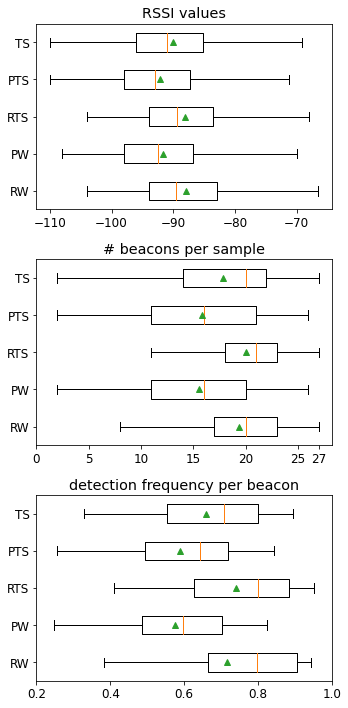

In [11]:
def plot_data(p,field,title,xticks):
    p.boxplot([all_data[x][field] for x in ['TS', 'PTS', 'RTS','PW','RW']],
             vert=False, 
             showfliers=False,
             showmeans=True,
             labels=['TS', 'PTS', 'RTS','PW','RW'])
    p.set_title(title)
    p.invert_yaxis()
    p.set_xticks(xticks)
    print(title)
    for x in ['TS', 'PTS', 'RTS','PW','RW']:
        print(x, np.quantile(all_data[x][field],[0.25,0.5,0.75]))

font = {'family' : 'normal',
        'size'   : 12}
pyplt.rc('font', **font)
pyplt.rcParams["figure.figsize"] = (5,10)

f, p = pyplt.subplots(3,1) #sharey=True)
plot_data(p[0],'rssi','RSSI values',[-110,-100,-90,-80,-70])
plot_data(p[1],'detections','# beacons per sample',[0,5,10,15,20,25,27])
plot_data(p[2],'bfreq','detection frequency per beacon',[0.2,0.4,0.6,0.8,1.0])
f.tight_layout()
f.get_figure().savefig("beacon_analysis_boxplots.pdf")